**IMPORT LIBRARY**

First, we must import the library

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, load_img
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**IMPORT DATASET USING KAGGLE**

Now, import the dataset using kaggle API (So you must download your API on Kaggle first)

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fariskurniawan","key":"66d11aa157fa8eba30e3333b958da435"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d imbikramsaha/paddy-doctor

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/paddy-doctor
License(s): CC0-1.0
100% 1.02G/1.02G [00:14<00:00, 72.4MB/s]
100% 1.02G/1.02G [00:14<00:00, 74.9MB/s]


**UNZIP THE FILE**

In [5]:
!unzip -q paddy-doctor.zip \
  && rm paddy-doctor.zip

**SPLIT THE DATASET FOR VALIDATION**

Because there is no directory for validation images, so we must create for that

In [6]:
dataset_path = "/content/paddy-disease-classification"
train_dir = os.path.join(dataset_path, "train_images")

In [7]:
import shutil
validation_dir = os.path.join(dataset_path, "validation_images")
os.makedirs(validation_dir, exist_ok=True)

In [8]:
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    val_cls_path = os.path.join(validation_dir, cls)
    os.makedirs(val_cls_path, exist_ok=True)
    images = os.listdir(cls_path)
    np.random.shuffle(images)
    val_count = int(0.2 * len(images)) #0.2 for validation images
    for img in images[:val_count]:
        shutil.move(os.path.join(cls_path, img), os.path.join(val_cls_path, img))

**EDA (Exploratory Data Analysis)**

Now we're gonna explore the data

Number of Classes: 10
Name of Classes: ['brown_spot', 'bacterial_leaf_blight', 'downy_mildew', 'normal', 'bacterial_panicle_blight', 'bacterial_leaf_streak', 'blast', 'dead_heart', 'hispa', 'tungro']


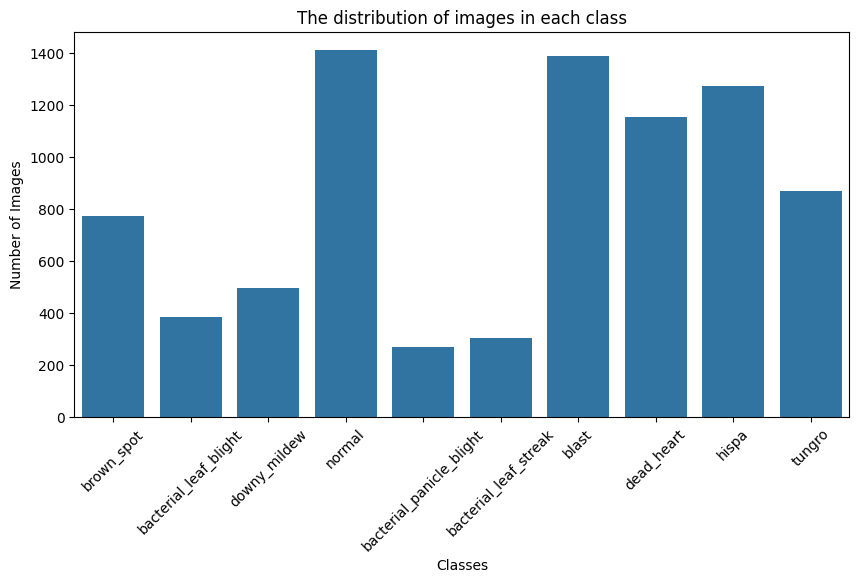

In [9]:
def perform_eda(train_dir):
    classes = os.listdir(train_dir)
    print(f"Number of Classes: {len(classes)}")
    print(f"Name of Classes: {classes}")

    class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=45)
    plt.title("The distribution of images in each class")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

perform_eda(train_dir)

**IMAGE AUGMENTATION**

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


**USING CLASS WEIGHT**

Because the spread of data is quiet bad, so we're gonna using class weight to make it balanced for each other.

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_labels)),
    y=np.concatenate([np.full(len(train_generator.filepaths[i]), i) for i in range(len(class_labels))])
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}


**PRE TRAINED MODEL**

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(229, 229, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 227, 227, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 113, 113, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,887,434 (18.64 MB)

 Trainable params: 4,887,434 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), metrics=['accuracy'])

In [14]:
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator,
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 151s 993ms/step - accuracy: 0.1723 - loss: 2.1777 - val_accuracy: 0.2388 - val_loss: 2.0579
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 954ms/step - accuracy: 0.2696 - loss: 2.0338 - val_accuracy: 0.3577 - val_loss: 1.8297
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 131s 956ms/step - accuracy: 0.3678 - loss: 1.8266 - val_accuracy: 0.4362 - val_loss: 1.6192
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 943ms/step - accuracy: 0.4031 - loss: 1.6982 - val_accuracy: 0.4786 - val_loss: 1.5133
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 954ms/step - accuracy: 0.4449 - loss: 1.6062 - val_accuracy: 0.4319 - val_loss: 1.6592


**USING TRANSFER LEARNING (EfficientNetB0)**

In [15]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
base_model.trainable = True

In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

In [18]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,411,693 (16.83 MB)

 Trainable params: 4,369,670 (16.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [19]:
history = model.fit(
    train_generator,
    epochs=65,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.1264 - loss: 2.3709 - val_accuracy: 0.1690 - val_loss: 2.2597
Epoch 2/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.2027 - loss: 2.1857 - val_accuracy: 0.1700 - val_loss: 2.2369
Epoch 3/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 998ms/step - accuracy: 0.2669 - loss: 2.0644 - val_accuracy: 0.1623 - val_loss: 2.2125
Epoch 4/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 976ms/step - accuracy: 0.3218 - loss: 1.9520 - val_accuracy: 0.1685 - val_loss: 2.2210
Epoch 5/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4016 - loss: 1.7645 - val_accuracy: 0.2802 - val_loss: 2.0835
Epoch 6/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4434 - loss: 1.6230 - val_accuracy: 0.3813 - val_loss: 1.7982
Epoch 7/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.4783 - loss: 1.4996 - val_accuracy: 0.5142 - val_loss: 1.4081
Epoch 8/65
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4986 - loss: 1.4039 - va

**PLOT FOR ACCURACY AND LOSS**

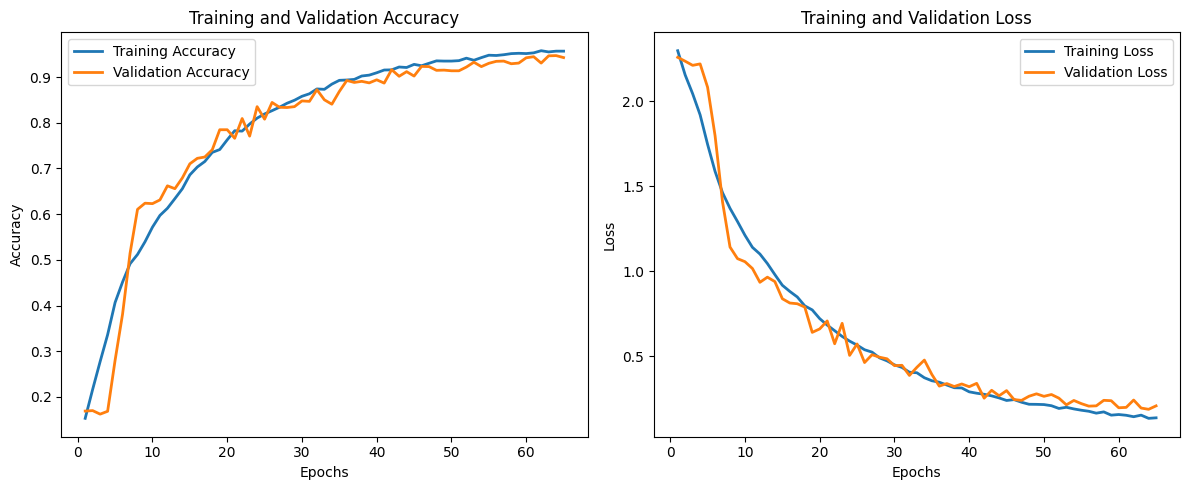

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


**USING FINE TUNING**

taking a smart model that already knows a lot and giving it a bit of extra training so it becomes really good at a specific task.

In [21]:
base_model.trainable = True

In [22]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), #With lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9591 - loss: 0.1367 - val_accuracy: 0.9442 - val_loss: 0.1983
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9611 - loss: 0.1310 - val_accuracy: 0.9451 - val_loss: 0.1939
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 135s 982ms/step - accuracy: 0.9601 - loss: 0.1368 - val_accuracy: 0.9461 - val_loss: 0.1913
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 991ms/step - accuracy: 0.9648 - loss: 0.1196 - val_accuracy: 0.9466 - val_loss: 0.1912
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9693 - loss: 0.1162 - val_accuracy: 0.9461 - val_loss: 0.1931
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9604 - loss: 0.1313 - val_accuracy: 0.9475 - val_loss: 0.1859
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9622 - loss: 0.1331 - val_accuracy: 0.9461 - val_loss: 0.1909
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 990ms/step - accuracy: 0.9619 - loss: 0.1236 -

**TESTING**

Saving 110355.jpg to 110355.jpg


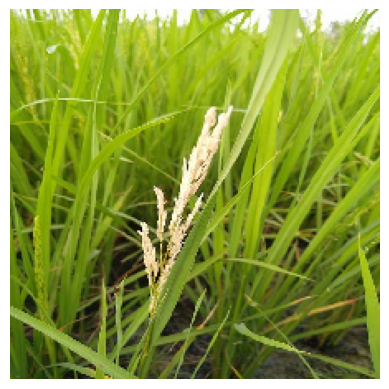

Prediction probabilities:
bacterial_leaf_blight: 0.00%
bacterial_leaf_streak: 0.00%
bacterial_panicle_blight: 0.00%
blast: 0.00%
brown_spot: 0.00%
dead_heart: 100.00%
downy_mildew: 0.00%
hispa: 0.00%
normal: 0.00%
tungro: 0.00%

Result:
dead_heart: 100.00%


In [24]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for filepath in uploaded.keys():
    img = image.load_img(filepath, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    proba = model.predict(x, verbose=0)[0]

    print("Prediction probabilities:")
    for label, probability in zip(labels, proba):
        print(f"{label}: {probability * 100:.2f}%")

    max_index = np.argmax(proba)
    max_label = labels[max_index]
    max_proba = proba[max_index]

    print("\nResult:")
    if max_proba >= 0.5:
        print(f"{max_label}: {max_proba * 100:.2f}%")
    else:
        print("Hasil tidak ditemukan!")


**CONFUSSION MATRIX**

With confussion matrix, we can see how much the predict label can be a true label

Found 2077 images belonging to 10 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step


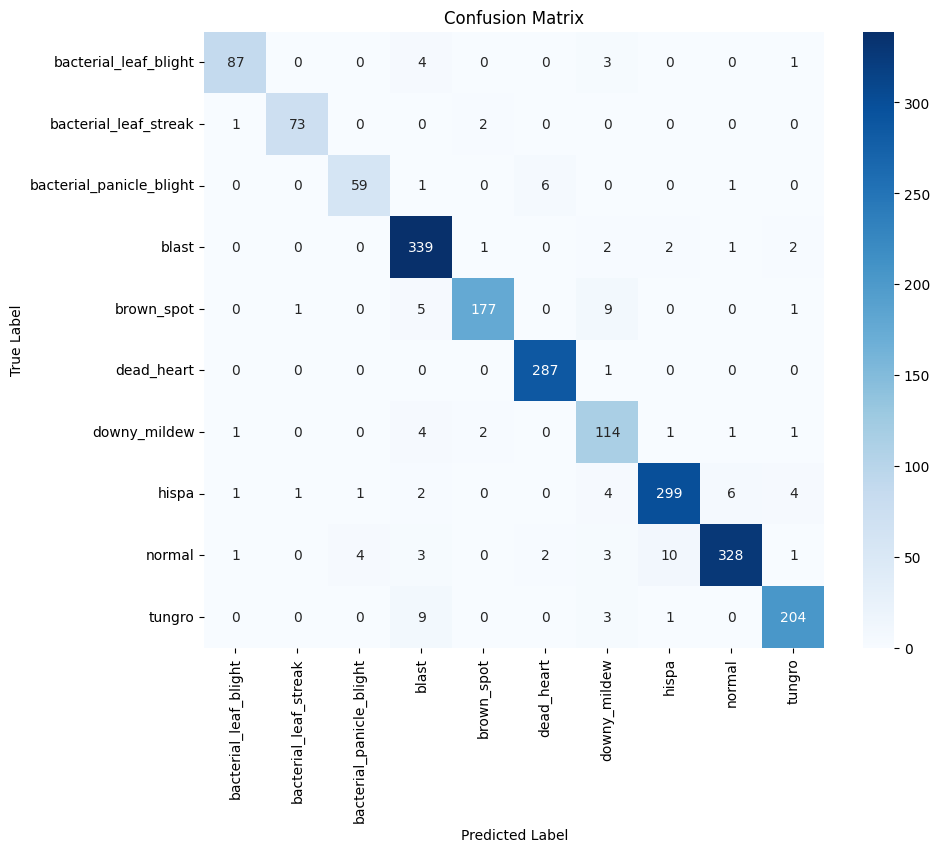

Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.96      0.92      0.94        95
   bacterial_leaf_streak       0.97      0.96      0.97        76
bacterial_panicle_blight       0.92      0.88      0.90        67
                   blast       0.92      0.98      0.95       347
              brown_spot       0.97      0.92      0.94       193
              dead_heart       0.97      1.00      0.98       288
            downy_mildew       0.82      0.92      0.87       124
                   hispa       0.96      0.94      0.95       318
                  normal       0.97      0.93      0.95       352
                  tungro       0.95      0.94      0.95       217

                accuracy                           0.95      2077
               macro avg       0.94      0.94      0.94      2077
            weighted avg       0.95      0.95      0.95      2077



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(true_classes, y_pred, target_names=class_labels))


**SAVE THE MODEL**

In [26]:
model.save('model_padicare.h5')

In [27]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model_padicare.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp1dwav8c4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137739005277664: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137739005278720: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137739005302864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005301984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005298288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005297232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005301280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005306912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005306560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137739005308320: TensorSpec(shape=(), dtype=tf.resource, name=No